# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import os, sys, joblib, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import sctk as sk
# import bbknn

expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1

# Load data

In [ ]:
fetal_ad = sc.read("../data/h5ad/fetal_skin_raw.20190926.h5ad")

In [ ]:
hierarchy1 = pd.read_csv(
    "../2019_pass1_data_processing/hierarchy1.txt", sep="\t", index_col=0
)

In [18]:
hierarchy1.head(2)

,hierarchy1
index,
AAACCTGGTCAGTGGA-1-4834STDY7002879,1
AAAGATGGTCGATTGT-1-4834STDY7002879,1


In [19]:
sk.show_obs_categories(fetal_ad)

cell_caller, 3
Both    193381
Cell      6183
Empt     35637
Name: cell_caller, dtype: int64


sanger_id, 45
4834STDY7002879     965
4834STDY7002880     636
4834STDY7002883    1374
4834STDY7038752     406
4834STDY7038753    1150
FCAImmP7241240      687
FCAImmP7241241     5691
FCAImmP7316886     5767
FCAImmP7316887     5533
FCAImmP7316888     6860
FCAImmP7316896     3264
FCAImmP7316897     8204
FCAImmP7352189     2818
FCAImmP7352190     6884
FCAImmP7352191     7164
FCAImmP7462240     3642
FCAImmP7462241     5171
FCAImmP7528290     5185
FCAImmP7528291     5422
FCAImmP7528296     4882
FCAImmP7555848     3590
FCAImmP7555858     3338
FCAImmP7579212     2534
FCAImmP7579213     4240
FCAImmP7579224     2337
FCAImmP7803024     4530
FCAImmP7803025     6015
FCAImmP7803026     7704
FCAImmP7803027     7213
FCAImmP7803034     9099
FCAImmP7803035     7855
FCAImmP7803042     8604
FCAImmP7803043     7386
FCAImmP7862094     3314
FCAImmP7862095     8373
FCAImmP7862096     8423
FCAImmP7964502     3764
FCAI

# Process

## QC

In [ ]:
sk.calculate_qc(fetal_ad)

/nfs/team205/nh3/miniconda2/envs/scanpy-new/lib/python3.8/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


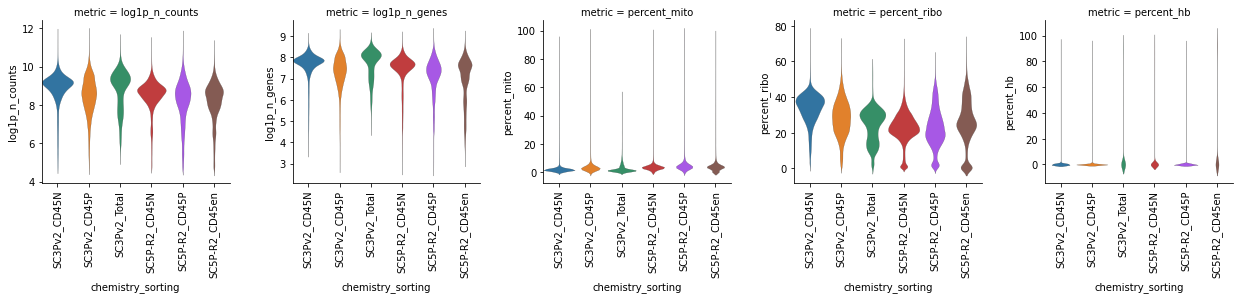

In [20]:
sk.plot_qc_violin(
    fetal_ad,
    metrics=[
        "log1p_n_counts",
        "log1p_n_genes",
        "percent_mito",
        "percent_ribo",
        "percent_hb",
    ],
    groupby="chemistry_sorting",
    rotation=90,
    figsize=(3.5, 3),
    scale="area",
)

/nfs/team205/nh3/miniconda2/envs/scanpy-new/lib/python3.8/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


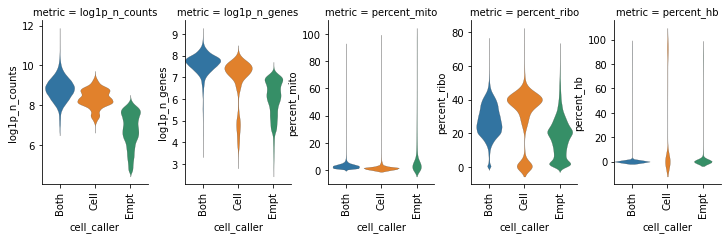

In [21]:
sk.plot_qc_violin(
    fetal_ad,
    metrics=[
        "log1p_n_counts",
        "log1p_n_genes",
        "percent_mito",
        "percent_ribo",
        "percent_hb",
    ],
    groupby="cell_caller",
    rotation=90,
    figsize=(2, 3),
    scale="area",
)

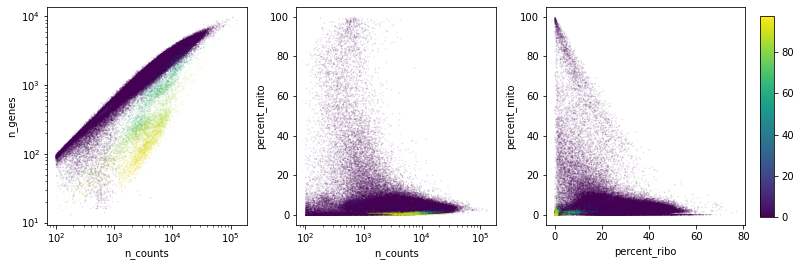

In [22]:
sk.plot_qc_scatter(
    fetal_ad,
    metric_pairs=[
        ("log1p_n_counts", "log1p_n_genes"),
        ("log1p_n_counts", "percent_mito"),
        ("percent_ribo", "percent_mito"),
    ],
    color_by="percent_hb",
    s=0.005,
    figsize=(4, 4),
)

In [ ]:
fetal_ad1 = fetal_ad[
    (fetal_ad.obs.n_genes >= 100)
    & (fetal_ad.obs.n_counts < 45000)
    & (fetal_ad.obs.percent_mito < 15)
]

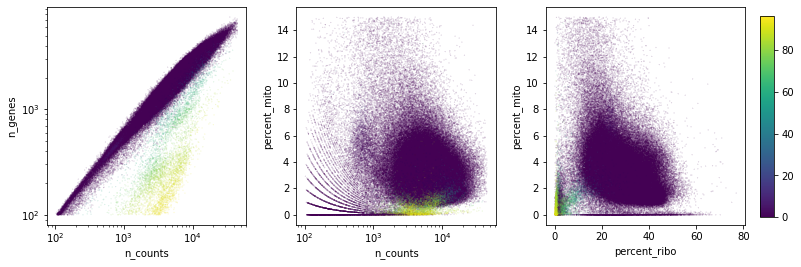

In [23]:
sk.plot_qc_scatter(
    fetal_ad1,
    metric_pairs=[
        ("log1p_n_counts", "log1p_n_genes"),
        ("log1p_n_counts", "percent_mito"),
        ("percent_ribo", "percent_mito"),
    ],
    color_by="percent_hb",
    s=0.005,
    figsize=(4, 4),
)

## Annotate

In [ ]:
ad = sk.simple_default_pipeline(
    fetal_ad1.copy(),
    post_filter_only=True,
    batch="donor",
    batch_method="bbknn",
    zero_center=False,
    do_clustering=True,
    clustering_resolution=[0.3],
    pca_kw={
        "n_comps": 50,
    },
    bk_kw={"neighbors_within_batch": 2},
)

In [24]:
ad

AnnData object with n_obs × n_vars = 226049 × 28816
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'leiden_bk_r0_3'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_bk', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap_bk'
    varm: 'PCs'
    obsp: 'neighbors_bk_distances', 'neighbors_bk_connectivities'

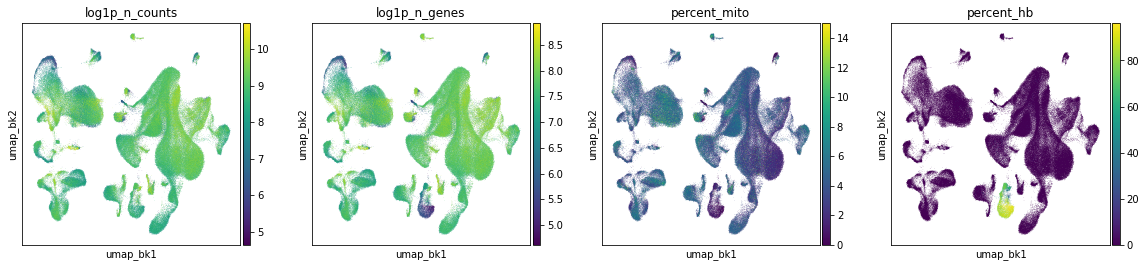

In [30]:
sk.set_figsize((4, 4))
sc.pl.embedding(
    ad,
    basis="umap_bk",
    color=["log1p_n_counts", "log1p_n_genes", "percent_mito", "percent_hb"],
)

In [26]:
ad.obs["doublet"] = (ad.obs["doublet_pval"] < 0.1).astype("category")
ad.obs["bh_doublet"] = (ad.obs["bh_doublet_pval"] < 0.1).astype("category")

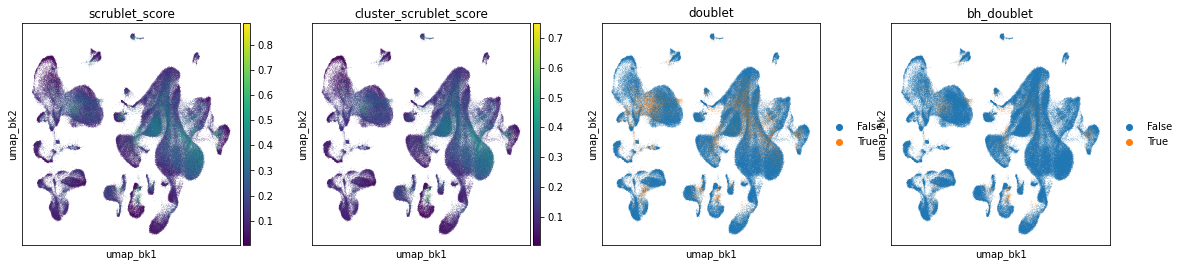

In [28]:
sc.pl.embedding(
    ad,
    basis="umap_bk",
    color=["scrublet_score", "cluster_scrublet_score", "doublet", "bh_doublet"],
)

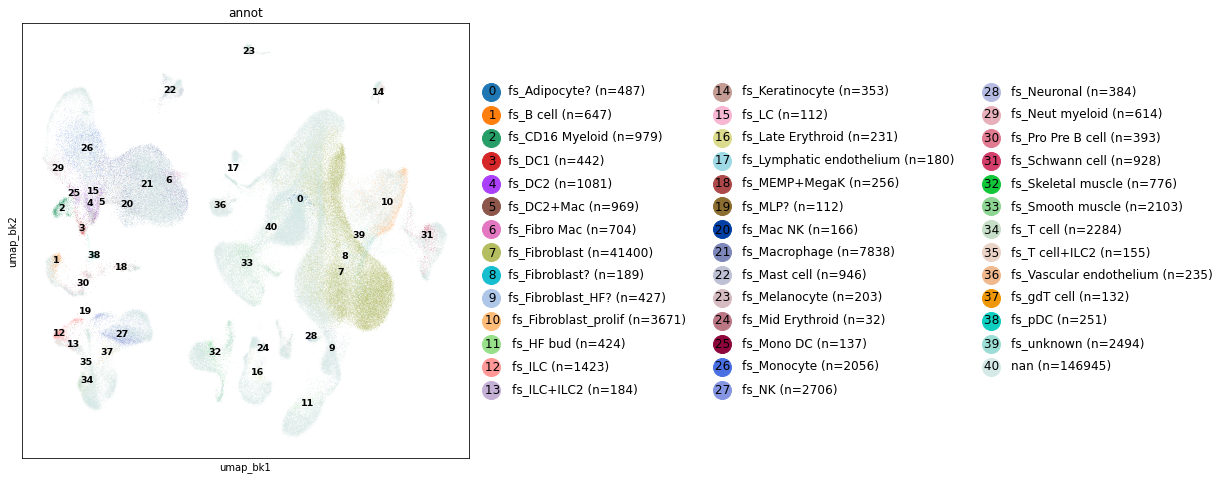

In [31]:
sk.plot_embedding(
    ad,
    basis="umap_bk",
    groupby="annot",
    annot="full",
    figsize=(8, 8),
);

In [32]:
k_annot = ad.obs["annot"].astype(str) != "nan"

In [36]:
lr = sk.LR_train(
    ad[k_annot, :],
    groupby="annot",
    use_rep="X_pca",
    downsample_to=(200, "tmp.h5ad"),
    save="rachel_annot_201904.pca.pkl",
)

In [37]:
sk.LR_predict(ad, lr, use_rep="X_pca", key_added="lr_annot")

50 features used for prediction


In [38]:
ad.obs["lr_annot"].cat.reorder_categories(
    list(np.sort(ad.obs["lr_annot"].unique())), inplace=True
)

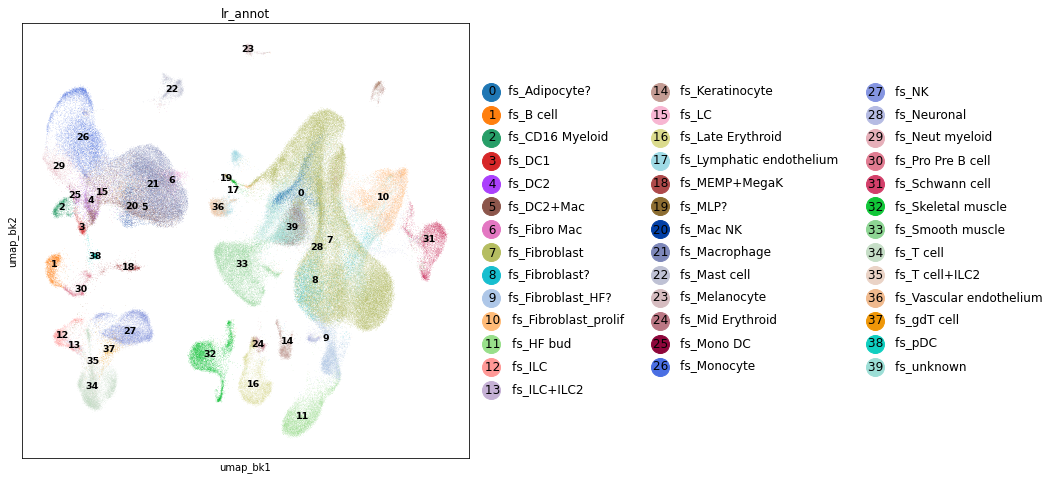

In [39]:
sk.plot_embedding(ad, basis="umap_bk", groupby="lr_annot", figsize=(8, 8));

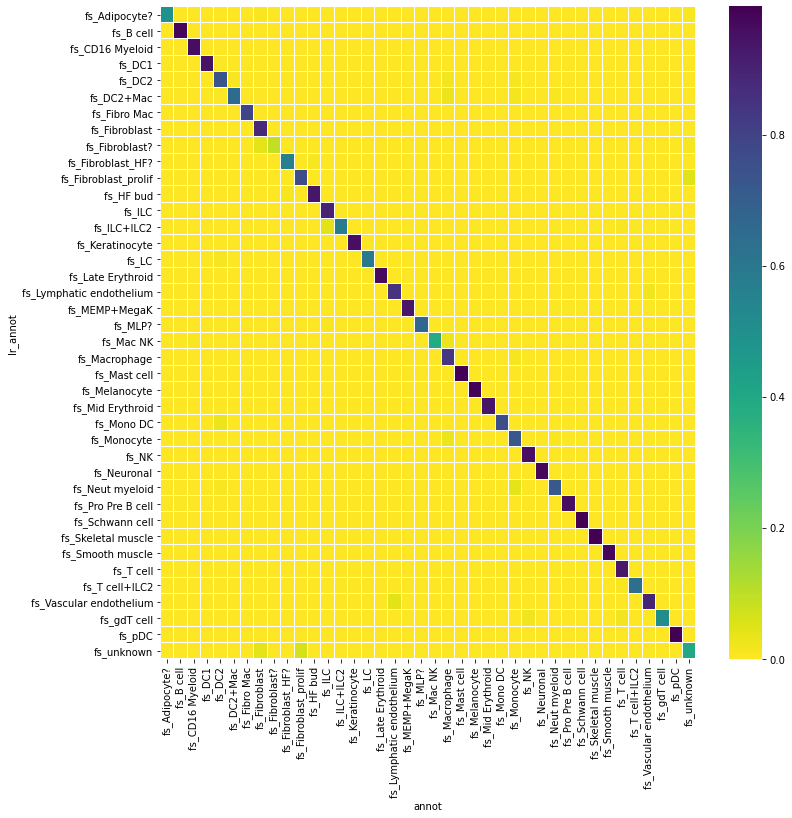

In [40]:
sk.heatmap(
    sk.cross_table(ad[ad.obs.annot != "nan"], "lr_annot", "annot", normalise="jaccard"),
    cmap="viridis_r",
    figsize=(12, 12),
);

In [ ]:
ad.obs = ad.obs.merge(hierarachy1, how="left", left_index=True, right_index=True)
ad.obs["hierarchy1"] = ad.obs["hierarchy1"].astype(int).astype(str).astype("category")

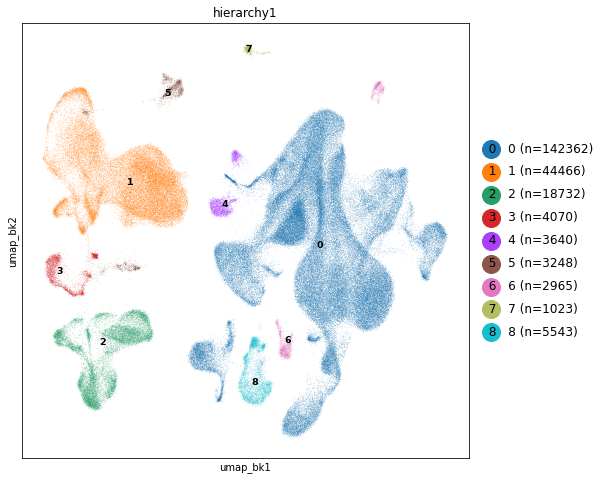

In [65]:
sk.plot_embedding(
    ad,
    basis="umap_bk",
    groupby="hierarchy1",
    annot="full",
    figsize=(8, 8),
);

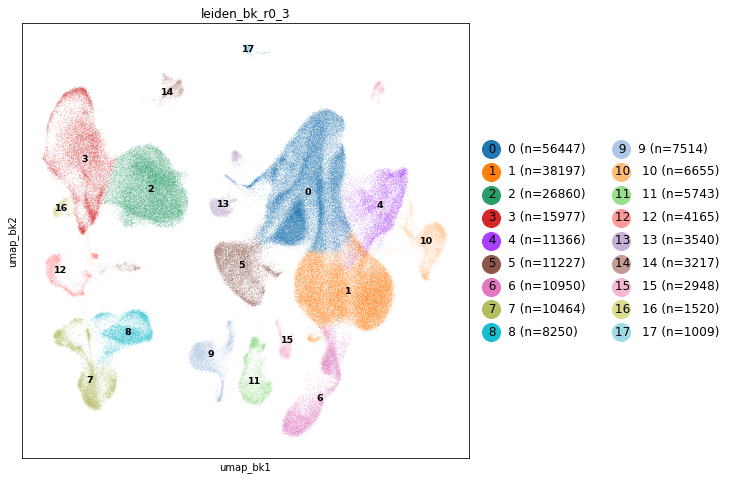

In [41]:
sk.plot_embedding(
    ad,
    basis="umap_bk",
    groupby="leiden_bk_r0_3",
    annot="full",
    figsize=(8, 8),
);

In [51]:
ad.obs["hierarchy1a"] = sk.regroup(
    ad,
    "leiden_bk_r0_3",
    {
        "0": ["0", "1", "4", "5", "6", "10", "9"],
        "1": ["2", "3", "16"],
        "2": ["7", "8"],
        "3": ["12"],
        "4": ["13"],
        "5": ["14"],
        "6": ["15"],
        "7": ["17"],
        "8": ["11"],
    },
)

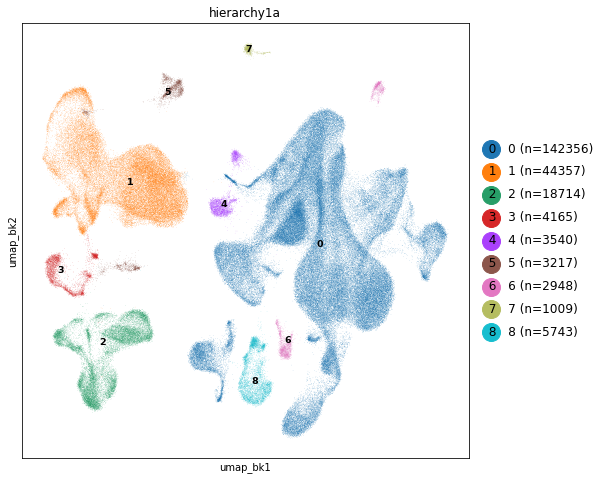

In [53]:
sk.plot_embedding(
    ad,
    basis="umap_bk",
    groupby="hierarchy1a",
    annot="full",
    figsize=(8, 8),
);

<AxesSubplot:xlabel='hierarchy1', ylabel='hierarchy1a'>

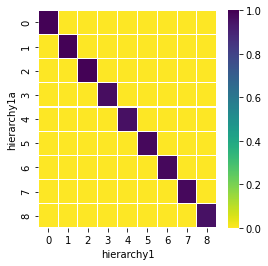

In [54]:
sk.heatmap(
    sk.cross_table(
        ad, "hierarchy1a", "hierarchy1", normalise="jaccard", include_nan=True
    ),
    vmin=0,
    vmax=1,
    cmap="viridis_r",
    figsize=(4, 4),
)

In [52]:
ad.obs["hierarchy1_diff"] = ad.obs["hierarchy1"].astype(str) != ad.obs[
    "hierarchy1a"
].astype(str)

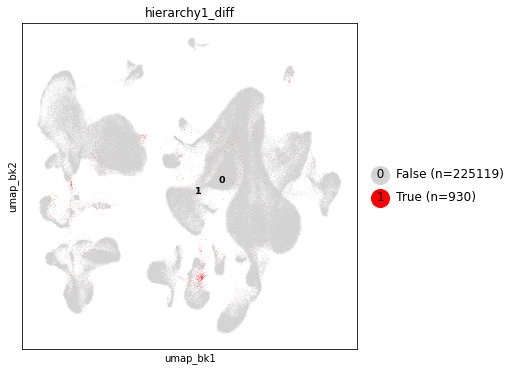

In [59]:
sk.plot_embedding(
    ad,
    basis="umap_bk",
    groupby="hierarchy1_diff",
    annot="full",
    size=1,
    figsize=(6, 6),
    palette=["lightgrey", "red"],
);

/nfs/team205/nh3/miniconda2/envs/scanpy-new/lib/python3.8/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


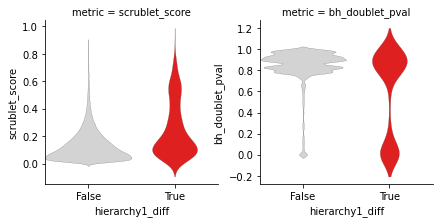

In [60]:
sk.plot_qc_violin(
    ad,
    metrics=["scrublet_score", "bh_doublet_pval"],
    groupby="hierarchy1_diff",
    scale="area",
    figsize=(3, 3),
);

Suggests that old and current broad categories are quite consistent. Inconsistent cells are enriched for doublets that are likely removed anyway.

Use old categories for consistency down-stream.

In [ ]:
ad.obs["hierarchy1"].cat.rename_categories(
    {
        "0": "Stroma",
        "1": "Myeloid",
        "2": "Lymphoid(T/NK)",
        "3": "Lymphoid(B/pDC)",
        "4": "Endothelium",
        "5": "Mast",
        "6": "Keratinocytes",
        "7": "Melanocytes",
        "8": "Erythroid",
    },
    inplace=True,
)

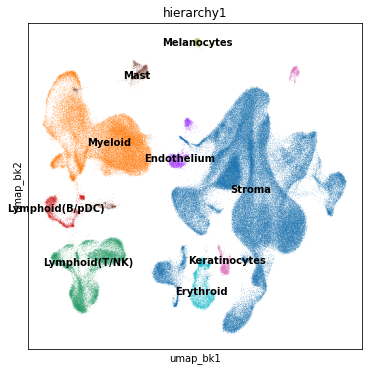

In [67]:
sk.set_figsize((6, 6))
sc.pl.embedding(
    ad,
    basis="umap_bk",
    color="hierarchy1",
    legend_loc="on data",
);

In [78]:
sk.clear_colors(ad)
ad.write("fetal_skin_processed.hierarchy1.h5ad", compression="gzip")

## Plot

In [68]:
cd45p = (
    ad.obs.loc[ad.obs["sorting"] == "CD45P"]
    .groupby(["pcw", "hierarchy1"])
    .size()
    .reset_index()
    .rename(columns={0: "count", "hierarchy1": "type"})
    .pivot(index="pcw", columns="type", values="count")
    .fillna(0)
)

cd45n = (
    ad.obs.loc[ad.obs["sorting"] == "CD45N"]
    .groupby(["pcw", "hierarchy1"])
    .size()
    .reset_index()
    .rename(columns={0: "count", "hierarchy1": "type"})
    .pivot(index="pcw", columns="type", values="count")
    .fillna(0)
)

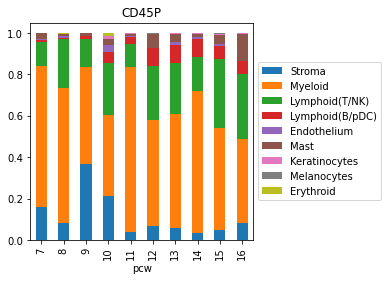

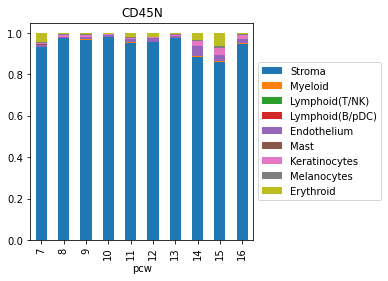

In [69]:
sk.set_figsize((4, 4))
ax = (cd45p.T / cd45p.sum(axis=1)).T.plot(kind="bar", stacked=True, title="CD45P")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax = (cd45n.T / cd45n.sum(axis=1)).T.plot(kind="bar", stacked=True, title="CD45N")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [70]:
ad.obs["HF_bud"] = ad.obs["lr_annot"] == "fs_HF bud"
ad.obs["HF_bud"] = (
    ad.obs["HF_bud"]
    .astype("category")
    .cat.rename_categories({True: "HF bud", False: "Others"})
)

In [71]:
stroma1 = (
    ad.obs.loc[(ad.obs["hierarchy1"] == "Stroma") & (ad.obs["sorting"] == "CD45N")]
    .groupby(["pcw", "HF_bud"])
    .size()
    .reset_index()
    .rename(columns={0: "count", "HF_bud": "type"})
    .pivot(index="pcw", columns="type", values="count")
    .fillna(0)
    .sort_index(axis=1)
)
stroma2 = (
    ad.obs.loc[(ad.obs["hierarchy1"] == "Stroma") & (ad.obs["sorting"] == "CD45N")]
    .groupby(["pcw", "lr_annot"])
    .size()
    .reset_index()
    .rename(columns={0: "count", "lr_annot": "type"})
    .pivot(index="pcw", columns="type", values="count")
    .fillna(0)
    .sort_index(axis=1)
)

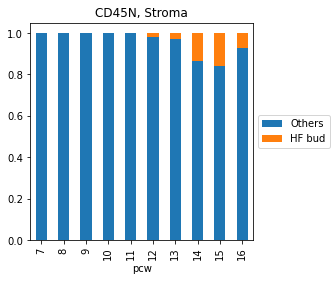

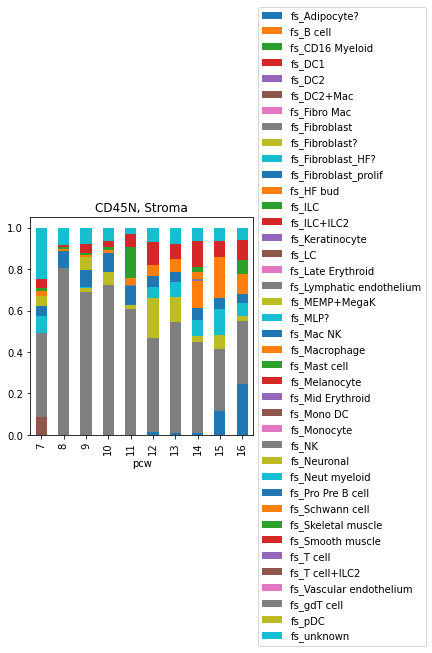

In [72]:
ax = (stroma1.T / stroma1.sum(axis=1)).T.plot(
    kind="bar", stacked=True, title="CD45N, Stroma"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax = (stroma2.T / stroma2.sum(axis=1)).T.plot(
    kind="bar", stacked=True, title="CD45N, Stroma"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [86]:
sk.clear_colors(ad)
ad.write("fetal_skin_bbknn.h5ad", compression="gzip")

# Split

In [75]:
ads = sk.split_by_group(ad, groupby="hierarchy1")

In [76]:
ads

{'Endothelium': AnnData object with n_obs × n_vars = 3640 × 28816
     obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'leiden_bk_r0_3', 'doublet', 'bh_doublet', 'lr_annot', 'lr_annot_prob', 'hierarchy1a', 'hierarchy1_diff', 'HF_bud'
     var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'log1p', 'hvg', 'pca', 'neighbors_bk', 'umap', 'leiden', 'doublet_colors', 'bh_doublet_colors', 'annot_colors', 'lr_annot_colors', 'leiden_bk_r0_3_colors', 'hierarchy1_colors', 'hierarchy1a_colors', 'hierarchy1_diff_colors', 'cell_caller_colors'
     obsm: 

In [77]:
gc.collect()

12321

In [79]:
ads.keys()

dict_keys(['Endothelium', 'Erythroid', 'Keratinocytes', 'Lymphoid(B/pDC)', 'Lymphoid(T/NK)', 'Mast', 'Melanocytes', 'Myeloid', 'Stroma'])

In [ ]:
for s, ct_ad in ads.items():
    ct = s.replace("/", "_").replace("(", "_").replace(")", "")
    sk.clear_colors(ad)
    ct_ad.write(f"fetal_skin.hierarchy1.{ct}.norm.h5ad", compression="gzip")